In [471]:
# Libraries
library(readxl)
library(stringr)
library(tidyr)
library(ggplot2)

In [472]:
# Adjust PATH
wd <- getwd()
subdir <- "/bin"
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
getwd()

[1] "/vol/projects/odietric/covid19-bal-atlas-integration"

In [473]:
# Variables
in_url <- "https://syncandshare.desy.de/index.php/s/CrDgDwHRQNDWYcj"
in_url <- paste0(in_url, "/download")
in_file <- "docs/overview.xlsx"
plot_dir <- "analysis/BCB/overview/"

# Colors
cols <- list(
  type = c(
      "Hospital" = "grey", 
      "ICU" = "gold", 
      "Ventilation" = "purple", 
      "ECMO" = "indianred"
  )
)

# Shape
shape <- list()
shape$sex <- c(
  "Male" = "\u2642", 
  "Female" = "\u2640"
)
shape$endpoint <- c(
  death = "\u2020",
  release = "\u00BB",
  unknown = "\u003F"
)

In [474]:
# Download data
download.file(in_url, in_file)

In [475]:
# Read data
data <- list()
sheets <- excel_sheets(in_file)
for (i in sheets) {
    data[[i]] <- read_excel(path = in_file, sheet = i)
}
names(data)

[1] "libraries"    "patients"     "samples"      "examinations" "hto_features"
[6] "hto_indices"

In [476]:
# Select sequenced libraries
libs <- data$libraries
libs$sequenced <- !is.na(libs$run)
libs <- libs[libs$sequenced, ]
nrow(libs)


# Select sequenced samples
samples <- data$samples
index <- unlist(str_split(samples$sample, ","))
index <- unlist(str_split(index, ":"))
index <- str_detect(index, "BAL")
samples$sequenced <- index

[1] 41

In [477]:
# Add patient data
patients <- data$patients
patients$sex <- str_trunc(patients$sex, 1, ellipsis = "")
patients$time <- difftime(patients$endpoint_date, patients$onset, units='days')
patients$onset_label <- as.Date(patients$onset, format="%h %Y")

In [478]:
# Calculate disease time
index <- match(samples$patient, patients$id)
samples$time <- difftime(samples$date, patients$onset[index], units='days')
samples$time[is.na(samples$time)] <- -5

In [479]:
# Add timelines
names(patients)
tl <- list()
tl[["Hospital"]] <- data.frame("from" = patients[["Hospital-admission"]],
                               "to"   = patients[["endpoint_date"]], 
                               "type" = "Hospital", patient = patients$id
                              )
tl[["ICU"]] <- data.frame("from" = patients[["ICU-admission"]],
                               "to"   = patients[["endpoint_date"]], 
                               "type" = "ICU", patient = patients$id
                              )
tl[["Ventilation"]] <- data.frame("from" = patients[["Ventilation-start"]],
                               "to"   = patients[["Ventilation-stop"]], 
                               "type" = "Ventilation", patient = patients$id
                              )
tl[["ECMO"]] <- data.frame("from" = patients[["ECMO-start"]],
                               "to"   = patients[["ECMO-stop"]], 
                               "type" = "ECMO", patient = patients$id
                              )
tl <- dplyr::bind_rows(tl)
tl$type <- factor(tl$type, unique(tl$type))
tl <- gather(tl, "order", "time", -type, -patient)
tl$time <- difftime(tl$time, patients$onset, units='days')

[1] "name"               "id"                 "cohort"            
 [4] "age"                "sex"                "outcome"           
 [7] "onset"              "vaccine_status"     "SCoV2_variant"     
[10] "date_PCR"           "Hospital-admission" "ICU-admission"     
[13] "ICU"                "Ventilation-start"  "Ventilation-stop"  
[16] "ECMO-start"         "ECMO-stop"          "endpoint_date"     
[19] "time"               "onset_label"

Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 213 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 27 rows containing missing values (`geom_point()`).”
Don't know how to automatically pick scale for object of type <difftime>.
Defaulting to continuous.
Warning message:
“Removed 1 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 213 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_text()`).”
Warning message:
“Removed 27 rows containing missing values (`geom_point()`).”


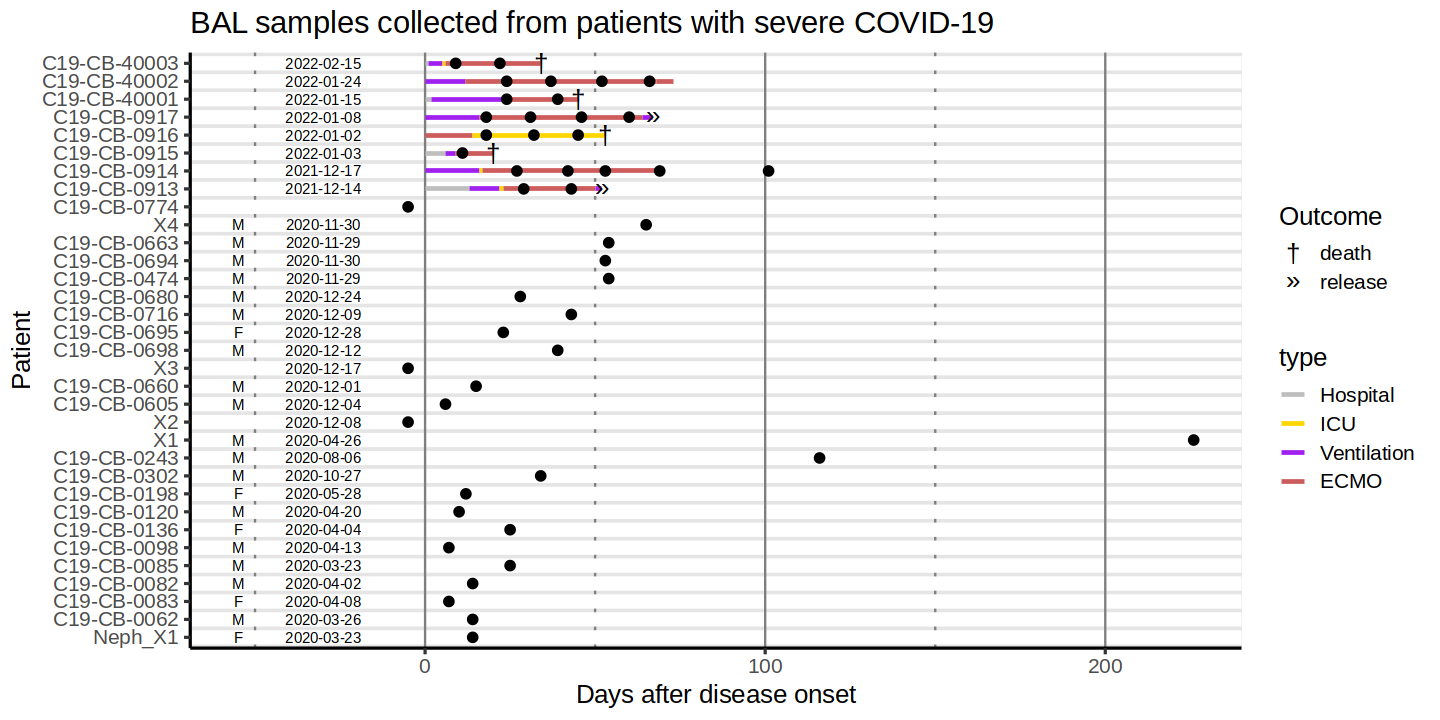

In [499]:
# Plot
options(repr.plot.width=12, repr.plot.height=6)
samples$patient <- factor(samples$patient, patients$id)
ggplot(samples, aes(time, patient)) +
geom_point(size = 1, shape = 21, stroke = 0, fill = "black") +
geom_text(data = patients, aes(-30, id, label = onset_label),  # Onset date
          size = 3, col = "black") +
geom_line(data = tl, aes(time, patient, col = type, group = patient), linewidth = 1) +
geom_text(data = patients, aes(-55, id, label = sex), # Sex
           col = "black", size=3) + 
geom_point(data = patients, aes(time, id, shape = outcome), # Outcome
           col = "black", size=5) +
geom_point(size = 3, shape = 21, stroke = 0, fill = "black") +
scale_shape_manual(values = shape$endpoint) +
scale_color_manual(values=cols$type) +
labs(x = "Days after disease onset", y = "Patient",
    title = "BAL samples collected from patients with severe COVID-19") +
ggplot2::theme_classic(15) +
    ggplot2::theme(
      strip.text.y = ggplot2::element_text(angle = 0),
      panel.background = ggplot2::element_rect(fill = "grey90"),
      panel.grid.major.y = ggplot2::element_line(color = "white", size = 3),
      panel.grid.major.x = ggplot2::element_line(size = .5, color = "grey50"),
      panel.grid.minor.x = ggplot2::element_line(size = .5, color = "grey50")
    ) +
guides(shape = guide_legend(title = "Outcome"))
fn <- paste0(plot_dir, "sample-overview.png")
ggsave(fn, width=12, height=6, bg="white")